# Tarea N°1 | Procesamiento de lenguaje natural


<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Profesor: Maria Raveau</em><br>

</div>

*20 de julio de 2025*

**Nombre estudiante**: Camilo Rivera Verdugo  

-----------

## 1. Descripción

Este proyecto aborda la extracción de contenido útil a partir de los textos de los cabildos provinciales de 2016, en el contexto de una solicitud hipotética realizada por una agencia gubernamental interesada en conocer las opiniones de los participantes.
A partir de los textos de fundamento, se realiza un análisis exploratorio y visual mediante procesamiento de lenguaje natural (NLP), con el objetivo de describir con mayor claridad los temas tratados por los ciudadanos en los cabildos.

In [ ]:
# Se importan las librerías necesarias

import pandas as pd
import numpy as np
import os
import nltk
from nltk.tokenize import word_tokenize
import stanza
from nltk.tokenize import sent_tokenize
from nltk.stem import SnowballStemmer
import re
from nltk import word_tokenize, bigrams
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
cabildos = pd.read_excel('data/raw/resultadocabildoprovincial.xlsx', engine='openpyxl', header=0)
cabildos.head()

,region_nombre,provincia_nombre,comuna_nombre,cabildo_id,cabildo_nombre,cabildo_direccion,num_mesa,pregunta_glosa,concepto_nombre,concepto_otro,tipo-eleccion,fundamento
0,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Autonomía/libertad,NaN,A,sin fundamento
1,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Sin fundamento
2,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,La descentralizacion de ser autonoma por ser z...
3,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Equidad de género,NaN,A,Sin fundamento
4,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Respeto/conservación de la naturaleza o medio ...,NaN,A,Sin fundamento


### 2. Elección del concepto y preprocesamiento

En esta sección se describe el proceso de selección del concepto a analizar, junto con las primeras etapas de limpieza y preprocesamiento de los textos. Este paso es útil para asegurar que los datos estén en condiciones óptimas para su análisis, permitiendo extraer posteriormente información útil a partir de los fundamentos entregados por los participantes.

In [42]:
cabildos.groupby('concepto_nombre').size().reset_index(name = "recuento").sort_values(by="recuento", ascending=False).head(10)

,concepto_nombre,recuento
82,Otro,7121
58,Igualdad,649
69,Justicia,619
9,A la salud,614
1,A la educación,611
41,Descentralización,610
100,Respeto/conservación de la naturaleza o medio ...,607
37,Democracia,604
86,"Plebiscitos, referendos y consultas",597
94,"Protección, promoción y respeto de los derecho...",582


In [11]:
concepto = 'Descentralización'  # Se selecciona este concepto para el análisis
df_concepto = cabildos[cabildos['concepto_nombre'] == concepto].copy()


In [13]:
df_concepto.head()

,region_nombre,provincia_nombre,comuna_nombre,cabildo_id,cabildo_nombre,cabildo_direccion,num_mesa,pregunta_glosa,concepto_nombre,concepto_otro,tipo-eleccion,fundamento
2,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,La descentralizacion de ser autonoma por ser z...
92,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",4,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,P,"18 integrantes estuvieron de acuerdo, 1 en des..."
143,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",5,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,Autonomia en la toma de decisiones a nivel com...
170,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",6,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,Sin fundamento
212,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",7,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,no tiene fundamentos


In [ ]:
# Eliminamos fundamentos que no aportan valor: 'sin fundamento', 'idem anterior', 'no tiene fundamentos'
df_concepto = df_concepto[~df_concepto['fundamento'].str.lower().isin(['sin fundamento', 'idem anterior', 'no tiene fundamentos'])]


In [ ]:
# Se crea el pipeline de procesamiento en español utilizando Stanza.
# Este pipeline incluye:
# - tokenize: divide el texto en oraciones y palabras
# - mwt: maneja palabras de múltiples tokens (multi-word tokens)
# - pos: asigna etiquetas gramaticales (sustantivo, adjetivo, etc.)
# - lemma: reduce las palabras a su forma base (ej: "comiendo" → "comer")
# - depparse: analiza las relaciones sintácticas entre palabras

nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma,depparse')

2025-07-20 19:03:02 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-07-20 19:03:02 INFO: Downloaded file to /root/stanza_resources/resources.json
2025-07-20 19:03:03 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2025-07-20 19:03:03 INFO: Using device: cuda
2025-07-20 19:03:03 INFO: Loading: tokenize
2025-07-20 19:03:05 INFO: Loading: mwt
2025-07-20 19:03:05 INFO: Loading: pos
2025-07-20 19:03:08 INFO: Loading: lemma
2025-07-20 19:03:09 INFO: Loading: depparse
2025-07-20 19:03:10 INFO: Done loading processors!


In [ ]:
# 1.- lemmatizar
def lemmatizer(text):  
    doc = nlp(text)
    return ' '.join([x.lemma for x in doc.sentences[0].words]) # Se saca una sola frase para reducir el tiempo

df_concepto['lemma'] = [lemmatizer(x) for x in df_concepto['fundamento']] # Se lemmatiza fundamento

In [ ]:
# 2.- limpieza básica de signos, dígitos y saltos de línea
df_concepto['lemma'] = df_concepto['lemma'].str.translate(str.maketrans('', '', string.punctuation))
df_concepto['lemma'] = df_concepto['lemma'].str.translate(str.maketrans('', '', string.digits))
df_concepto['lemma'] = df_concepto['lemma'].str.strip()
df_concepto['lemma'] = df_concepto['lemma'].str.replace('\n', ' ', regex=False)


In [ ]:
# 3.- eliminar filas con menos de 3 palabras lematizadas
df_concepto = df_concepto[[len(x.split()) > 2 for x in df_concepto['lemma']]]
df_concepto = df_concepto.reset_index(drop=True)

In [ ]:
# 4.- Se cargan stopwords y puntuaciones
esp_stop = stopwords.words('spanish')
signos = set(string.punctuation)


### 3. WordCloud de tokens/sustantivos

A continuación, se genera una nube de palabras construida únicamente con sustantivos lematizados extraídos de los fundamentos asociados al concepto “Descentralización”. Esta visualización permite identificar rápidamente los términos más frecuentes utilizados por los participantes. El análisis excluye stopwords y signos de puntuación para asegurar una interpretación más precisa del vocabulario relevante.

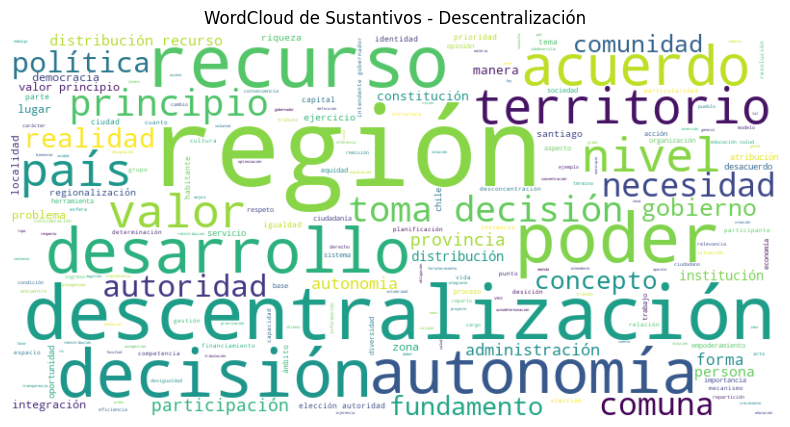

In [ ]:
sustantivos = []

for texto in df_concepto['lemma'].dropna():
    doc = nlp(texto)
    for sent in doc.sentences:
        for word in sent.words:
            if word.upos == 'NOUN': # Selecciona palabras que Stanza etiquetó como sustantivos
                lemma = word.lemma.lower()
                if lemma not in esp_stop and lemma not in signos:
                    sustantivos.append(lemma)

# WordCloud de sustantivos
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sustantivos))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Sustantivos - Descentralización")
plt.show()


Se observa que los participantes vinculan la descentralización principalmente con conceptos como **región, recursos, autonomía, desarrollo, territorio y poder**. Esto evidencia una preocupación por la **capacidad de gestión regional, la equidad en la distribución de recursos, y la autonomía de los territorios** para tomar decisiones que respondan a sus propias realidades.

### 4. WordCloud de bigrama sustantivo–adjetivo

Ahora vamos a visualizar los bigrama sustantivo–adjetivo más frecuentes presentes en los fundamentos asociados al concepto “Descentralización”.

In [44]:
bigramas_filtrados = []

for texto in df_concepto['lemma'].dropna():
    doc = nlp(texto)
    for sent in doc.sentences:
        lemmas = [(w.lemma.lower(), w.upos) for w in sent.words]
        for i in range(len(lemmas) - 1):
            if lemmas[i][1] == 'NOUN' and lemmas[i+1][1] == 'ADJ':
                # Eliminar dígitos
                s = re.sub(r'\d+', '', lemmas[i][0])
                a = re.sub(r'\d+', '', lemmas[i+1][0])
                if s and a:
                    bigramas_filtrados.append(f"{s} {a}")



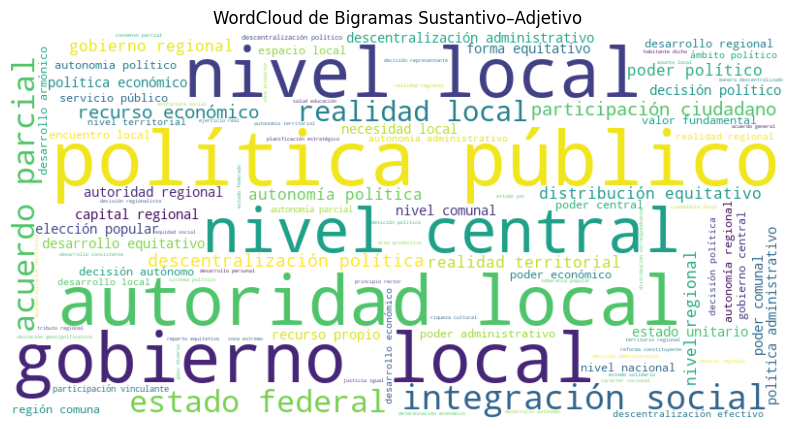

In [45]:
conteo_bigr_filtrados = Counter(bigramas_filtrados).most_common(100)

# Crear WordCloud desde frecuencias
data_filtrado = dict(conteo_bigr_filtrados)

wc = WordCloud(background_color='white', width=800, height=400, max_words=100).generate_from_frequencies(data_filtrado)

plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Bigramas Sustantivo–Adjetivo")
plt.show()


A partir del análisis del concepto “Descentralización” en los cabildos, se observa una fuerte asociación con ideas de **gobierno local, participación ciudadana y autonomía regional.** 
Los participantes vinculan este concepto con una **mayor capacidad de decisión en el nivel local y la necesidad de políticas públicas adaptadas a las realidades territoriales.**
También aparece con fuerza el componente **económico**, con énfasis en la distribución local de recursos y la demanda de autoridad política autónoma en regiones.

El concepto de descentralización parece ser visto como una herramienta para fortalecer la democracia, disminuir la centralización de recursos y mejorar la efectividad del Estado en los territorios.

### 5. Red de bigramas sustantivo–adjetivo

La siguiente red muestra las relaciones más frecuentes entre sustantivos y adjetivos en los fundamentos relacionados con el concepto “Descentralización”. Esta visualización permite observar cómo se asocian conceptualmente distintos términos.

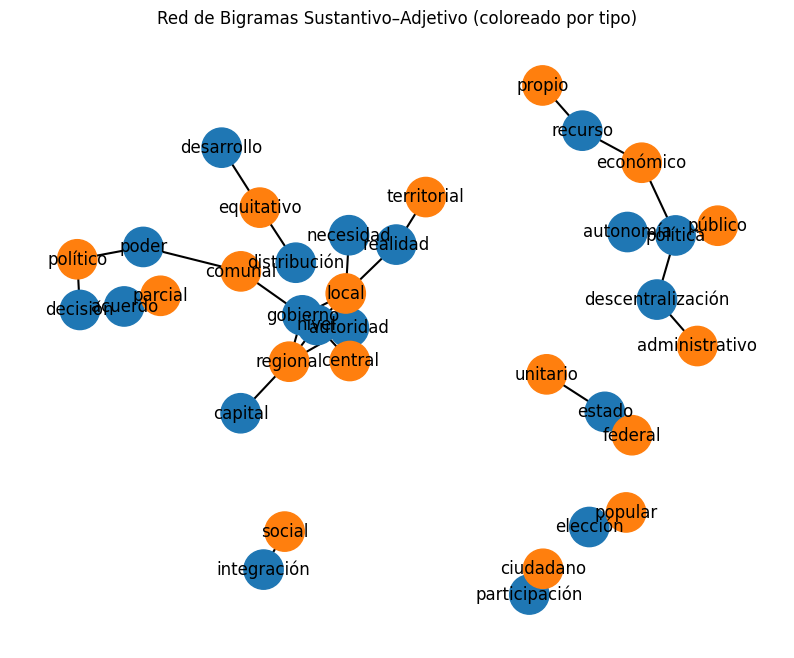

In [47]:
# Contar los bigramas más frecuentes
conteo_bigramas = Counter(bigramas_filtrados).most_common(30)

# Crear grafo y asignar tipo (sustantivo/adjetivo)
G = nx.Graph()
tipo_palabra = {}  # diccionario para guardar el tipo de nodo

for par, freq in conteo_bigramas:
    n1, n2 = par.split()
    G.add_edge(n1, n2, weight=freq)
    tipo_palabra[n1] = 'NOUN'
    tipo_palabra[n2] = 'ADJ'

# Colores personalizados
color_map = []
for node in G.nodes():
    if tipo_palabra.get(node) == 'NOUN':
        color_map.append('#1f77b4')  # azul para sustantivos
    elif tipo_palabra.get(node) == 'ADJ':
        color_map.append('#ff7f0e')  # naranjo para adjetivos
    else:
        color_map.append('gray')

# Dibujar red
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=800)
nx.draw_networkx_edges(G, pos, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=12)

plt.title("Red de Bigramas Sustantivo–Adjetivo (coloreado por tipo)")
plt.axis('off')
plt.show()

La red de bigramas muestra una fuerte presencia de asociaciones como **“gobierno local”, “política pública”, “recurso propio y “distribución equitativa”**, lo que evidencia que los participantes perciben la descentralización como un proceso ligado a autonomía política, gestión territorial efectiva y distribución equitativa de recursos. Estas conexiones ayudan a comprender cómo se estructuran los discursos en torno al concepto.

### 6. Frases de ejemplo para describir el concepto

A continuación, se presentan algunas frases textuales extraídas de los fundamentos ciudadanos vinculados al concepto “Descentralización”. Esto permite ver cómo los participantes argumentan sus ideas y relacionan los distintos conceptos.

In [55]:
df_concepto['fundamento'].dropna().sample(5, random_state=42).tolist()


['Acuerdo.',
 'Autoridades elegidas por votación popular  y que se contemple mecanismos de participación ciudadana.',
 'Chile es un país muy diverso por su geografía, debido a que la región de Magallanes es un territorio aislado con 60% de ASP es que se requiere de un poder mas amplio para planificar e implementar un desarrollo sostenible del territorio con énfasis en la consideración de la naturaleza.',
 'Las Regiones deben tener más facultades para la autogestión.',
 'AUTONOMÍA, DECISIÓN ACORDE AL TERRITORIO']

In [56]:
df_concepto[df_concepto['fundamento'].str.contains("autonomía", case=False, na=False)].sample(3)['fundamento'].tolist()


['Autonomía de las regiones y/o comunidades para tomar decisiones que les afecten. Más participación de localidades /comunidades  que son las que mejor conocen lo que tienen. Atención a realidades diversas, en diferentes ámbitos (Salud, educación, alimentación, entre otras)',
 'Asegurar un nivel de autonomía que radique en una esfera relevante de decisiones política en la región. Atribuir poder de decisión en el marco de las políticas del Estado, a los territorios en que se divide la organización político administrativa en la región',
 'permite dar las atribuciones necesarias a los territorios y sus autoridades para definir los procesos de desarrollo con autonomía.']

In [75]:
df_concepto[df_concepto['fundamento'].str.contains("desarrollo", case=False, na=False)].sample(3)['fundamento'].tolist()

['Es necesaria aunque se debe cuidar que no redunde en una situacion extrema que impida la conservacion de una identidad pais ademas se menciona que el concepto incluye al municipio. Este debe (palabra ilegible) en el desarrollo de liderazgos sociales y en la eleccion de los mismos.',
 'Fundamental en el desarrollo de las comunidades.\nFortalecimiento de municipios.',
 'Es importante considerar los recursos que (consi)generan las regiones para potenciar el desarrollo de las regiones.']

### 7. Conclusión

A partir del análisis de los fundamentos asociados al concepto “Descentralización”, se observa una clara demanda por **autonomía regional, mayor participación ciudadana y redistribución del poder y los recursos hacia los territorios.**

Las expresiones utilizadas por los participantes refuerzan ideas como autogestión, autoridades locales con poder de decisión, y la importancia de adaptar las políticas públicas a las realidades diversas de cada región.
Además, se destaca que la descentralización es vista como un mecanismo para impulsar el **desarrollo sostenible, fortalecer los liderazgos locales y asegurar una representación territorial efectiva** dentro de la estructura del Estado.

En conjunto, los resultados muestran que la descentralización es entendida como una herramienta para fortalecer la democracia territorial, otorgando mayor capacidad de decisión a las regiones y promoviendo un desarrollo más equilibrado entre los distintos territorios del país.

---------